# Projekt PRiAD - Klasyfikacja gwiazd
### Autorzy: Olga Kalisiak i Zuzanna Czyżowska

In [38]:
# Wymagane importy:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# import niezbędnych procedur pakietu scipy i scikit.learn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# zmiana sposobu wyświetlania danych typu float
pd.options.display.float_format = "{:.2f}".format 

# otwarcie pliku z danymi
dane1 = pd.read_csv('star_classification.csv')

# liczba obiektów
print("Liczba obiektów")
print(dane1.shape[0])

# liczba klas
print("Liczba klas")
print(len(set(dane1.iloc[:,-5])))

# liczba obiektów w każdej klasie
print("Liczba obiektów w klasie")
print(dane1.groupby("class").count().T.max())

# liczba atrybutów
print("Liczba atrybutów")
print(dane1.shape[1]-1)

# liczba danych brakujących
print("Liczba danych brakujących")
print(dane1.isna().sum().sum())

# usunięcie danych brakujących
dane = dane1.dropna()


Liczba obiektów
100000
Liczba klas
3
Liczba obiektów w klasie
class
GALAXY    59445
QSO       18961
STAR      21594
dtype: int64
Liczba atrybutów
17
Liczba danych brakujących
0


## Fragment danych

In [39]:
dane.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1237660961327743232.00,135.69,32.49,23.88,22.28,20.40,19.17,18.79,3606,301,2,79,6543777369295181824.00,GALAXY,0.63,5812,56354,171
1,1237664879951151104.00,144.83,31.27,24.78,22.83,22.58,21.17,21.61,4518,301,5,119,11760142036707334144.00,GALAXY,0.78,10445,58158,427
2,1237660961330430208.00,142.19,35.58,25.26,22.66,20.61,19.35,18.95,3606,301,2,120,5152200256025548800.00,GALAXY,0.64,4576,55592,299
3,1237663478724297984.00,338.74,-0.40,22.14,23.78,21.61,20.50,19.25,4192,301,3,214,10301071412954419200.00,GALAXY,0.93,9149,58039,775
4,1237680272041378048.00,345.28,21.18,19.44,17.58,16.50,15.98,15.54,8102,301,3,137,6891864880783316992.00,GALAXY,0.12,6121,56187,842


In [40]:
dane.tail()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
99995,1237678879964201472.00,39.62,-2.59,22.17,22.98,21.90,21.31,20.74,7778,301,2,581,10554306253273999360.00,GALAXY,0.00,9374,57749,438
99996,1237679476408647936.00,29.49,19.80,22.69,22.39,20.45,19.76,19.42,7917,301,1,289,8586350850183813120.00,GALAXY,0.40,7626,56934,866
99997,1237668298220634368.00,224.59,15.70,21.17,19.27,18.20,17.69,17.35,5314,301,4,308,3112007759562827776.00,GALAXY,0.14,2764,54535,74
99998,1237661151383454208.00,212.27,46.66,25.35,21.64,19.91,19.07,18.62,3650,301,4,131,7601079570549462016.00,GALAXY,0.46,6751,56368,470
99999,1237661151378801152.00,196.90,49.46,22.62,21.80,20.60,20.01,19.28,3650,301,4,60,8343152349989327872.00,GALAXY,0.54,7410,57104,851


## Analiza eksploracyjna

Wyjaśnienie danych:

0. obj_ID = Identyfikator obiektu: unikalna wartość identyfikująca obiekt
1. alpha = Kąt rektascencji
2. delta = Kąt deklinacji
3. u = Filtr ultrafioletowy w układzie fotometrycznym
4. g = Filtr zielony w układzie fotometrycznym
5. r = Filtr czerwony w układzie fotometrycznym
6. i = Filtr bliskiej podczerwieni w układzie fotometrycznym
7. z = Filtr podczerwieni w układzie fotometrycznym
8. run_ID = Numer uruchomienia używany do identyfikacji konkretnego skanowania
9. rerun_ID = Liczba powtórzeń określająca sposób przetwarzania obrazu
10. cam_col = Kamera do identyfikowania linii skanowania w trakcie pomiaru
11. field_ID = Numer pola do zidentyfikowania
12. spec_obj_ID = Unikalny identyfikator używany dla optycznych obiektów spektroskopowych (oznacza to, że 2 różne obserwacje o tym samym     spec_obj_ID muszą mieć tę samą klasę wyjściową)
13. class = klasa obiektu (obiekt galaktyki, gwiazdy lub kwazara)
14. redshift = wartość przesunięcia ku czerwieni w oparciu o wzrost długości fali
15. plate = Numer płyty w SDSS
16. MJD = Zmodyfikowana data juliańska, używana do wskazania, kiedy dany fragment danych SDSS został pobrany
17. fiber_ID = identyfikator światłowodu, który identyfikuje włókno, które skierowało światło na płaszczyznę ogniskową w każdej obserwacji

## Korelacja i wybór atrybutów
Na wstępie z analizy możemy wyrzucić kolumnę z atrybutem decyzyjnym 'class', ponieważ nie bierze on udziału w analizie eksploracyjnej

In [41]:
data0 = dane.drop(columns = ['class'])

Możemy również zauważyć, że atrybut rerun_ID zawsze przyjmuje taką samą wartość (301), daltego jest zbędny w analizie

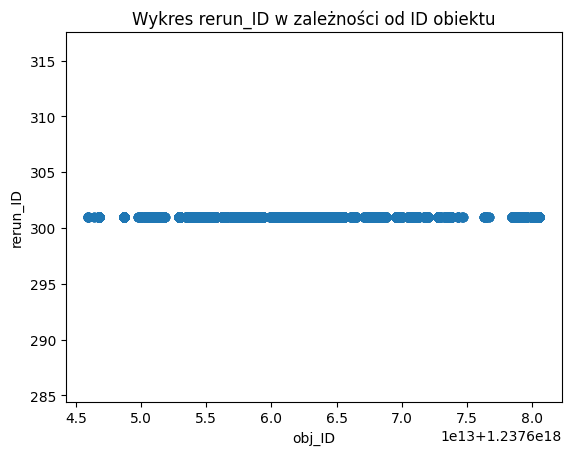

In [42]:
df = pd.DataFrame(data0)

unique_pairs = df[['obj_ID', 'rerun_ID']].drop_duplicates()

plt.scatter(unique_pairs['obj_ID'], unique_pairs['rerun_ID'])

plt.xlabel('obj_ID')
plt.ylabel('rerun_ID')

plt.title('Wykres rerun_ID w zależności od ID obiektu')

plt.show()

Usunięcie atrybutu rerun_ID

In [43]:
data = data0.drop(columns = ['rerun_ID'])

Teraz przedstawimy macierz korelacji pozostałych atrybutów, aby wybrać te, które będą najbardziej przydatne w procesie uczenia

<Axes: >

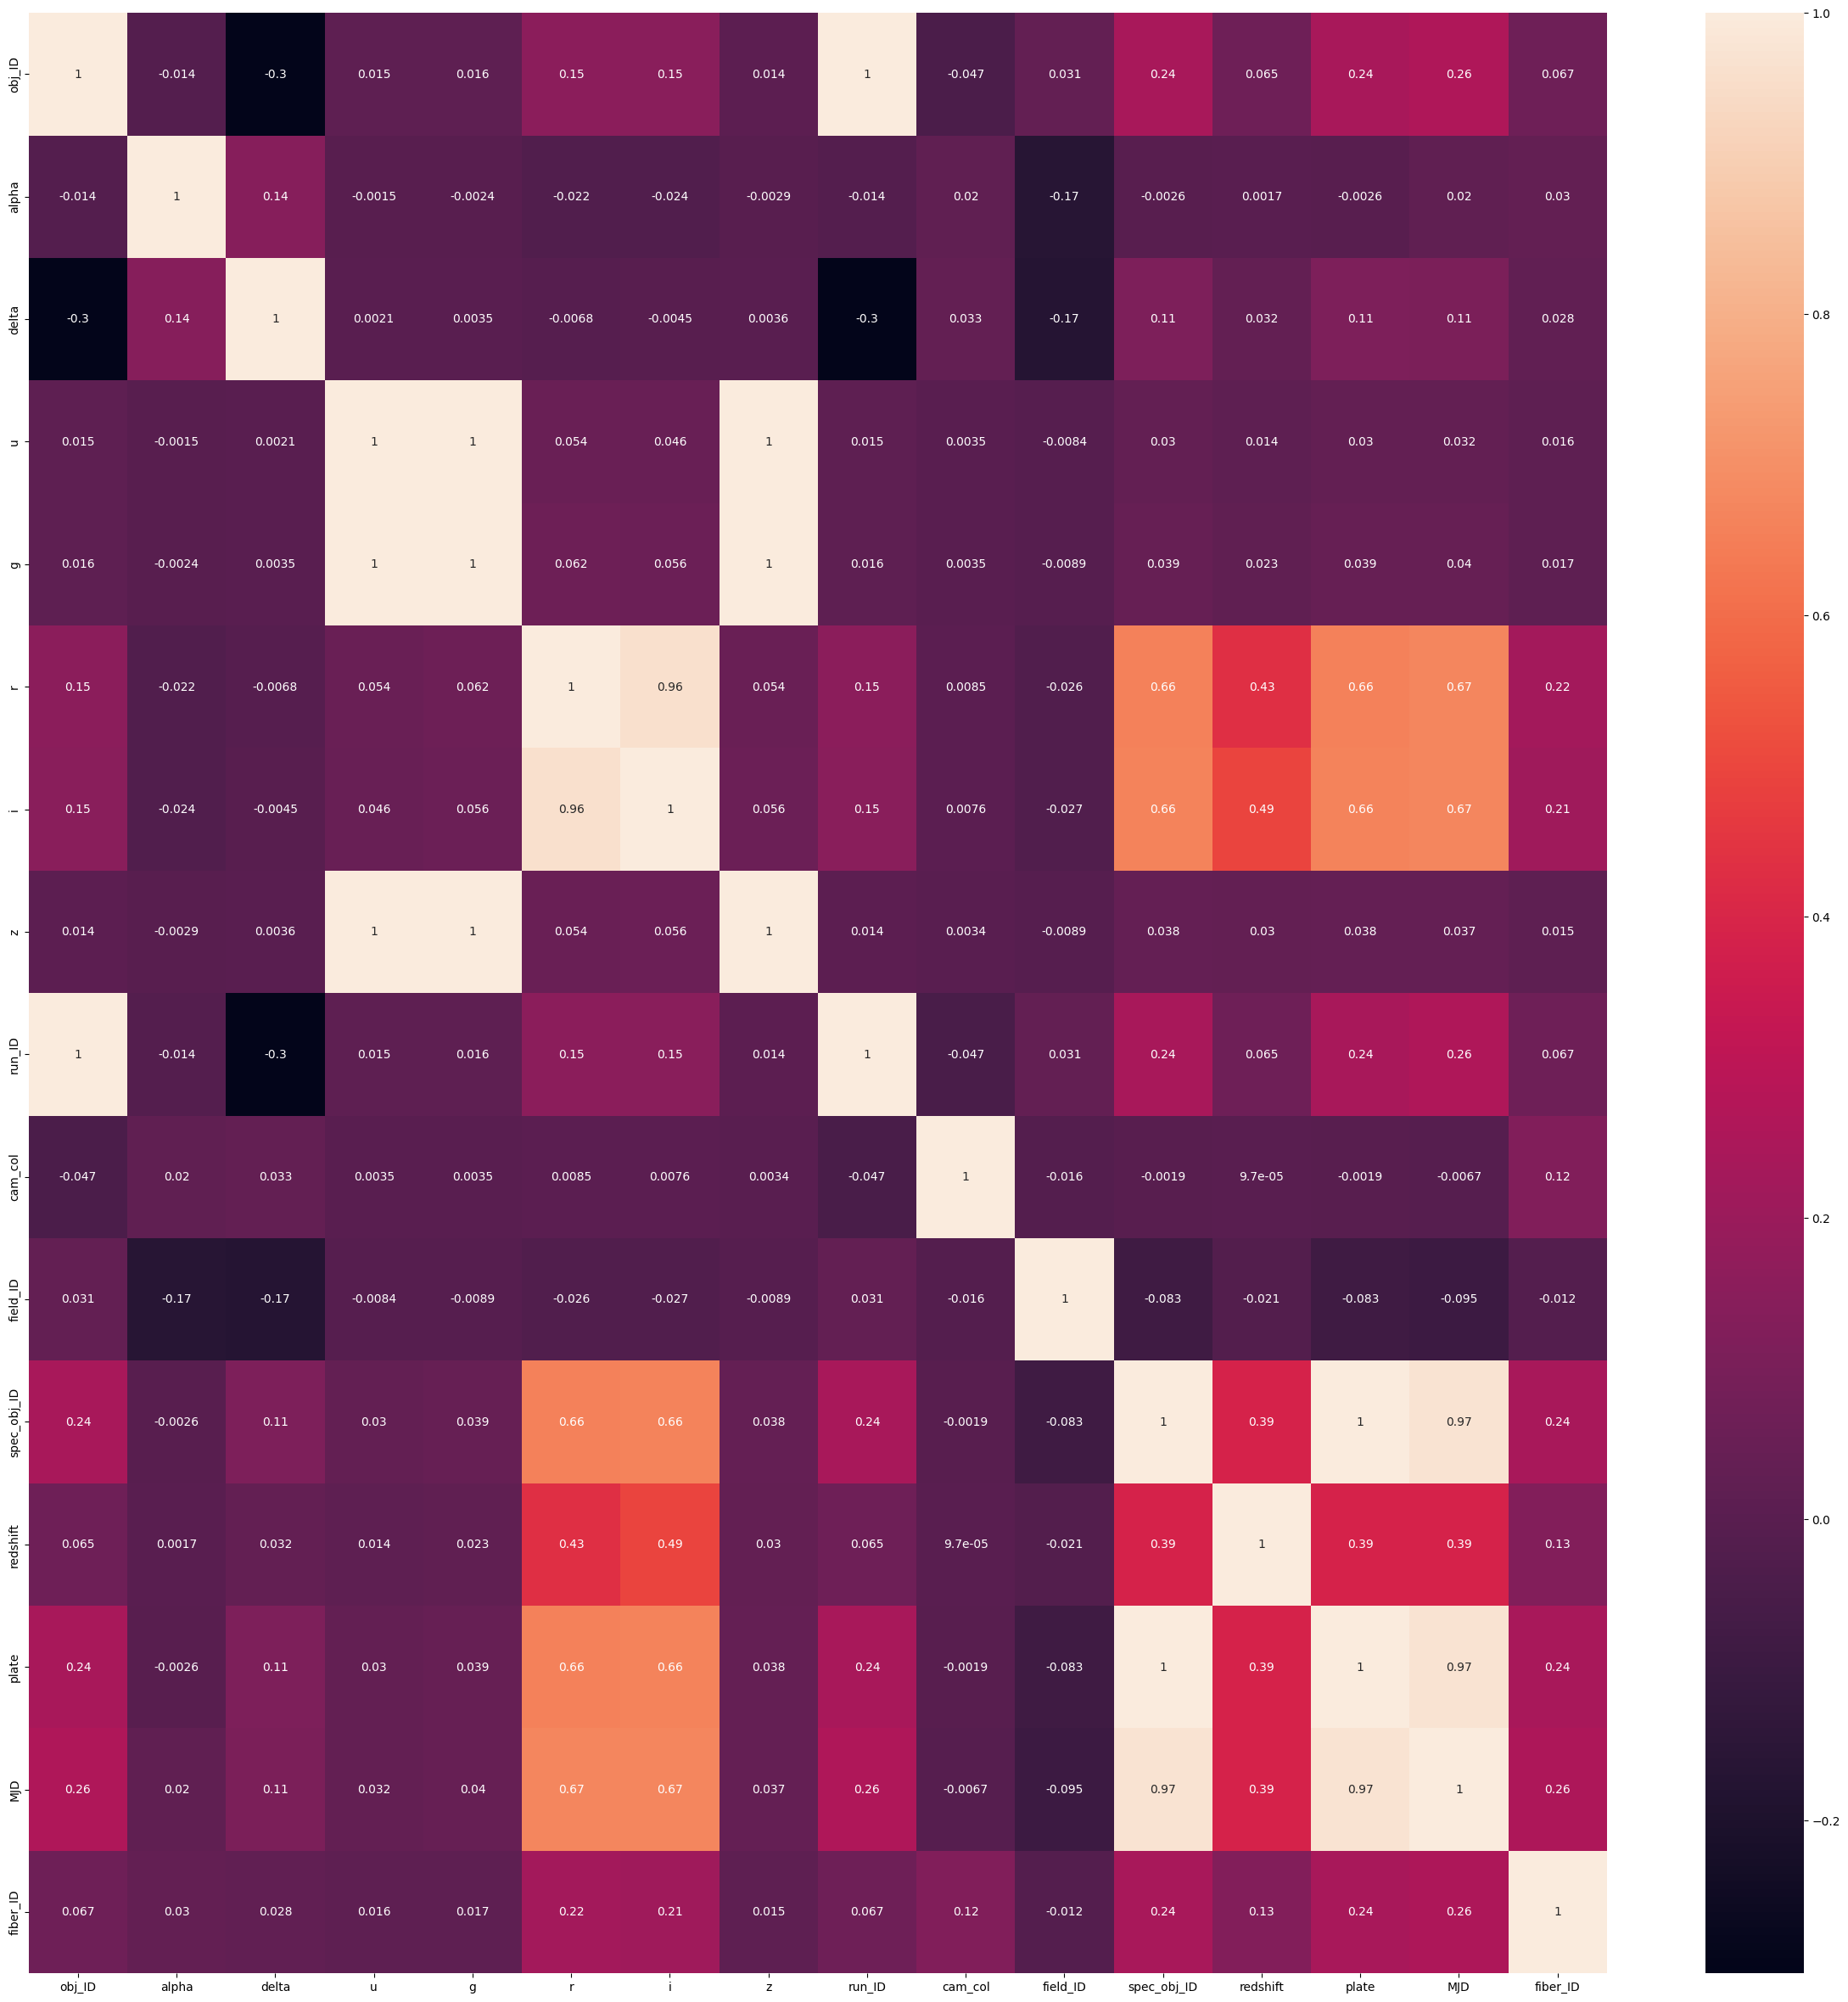

In [44]:
plt.figure(figsize=(30,30),dpi = 100)
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix,annot = correlation_matrix)

### Wybór atrybutów do analizy, na podstawie ustalonej korelacji
Najmniej skorelowane ze sobą poniższe atrybuty, ponieważ na macierzy korelacji, średnie wartości w ich komórkach są nabliższe 0: 
- 'alpha'
- 'delta'
- 'u' 
- 'g'
- 'r'
- 'i'
- 'z'
- 'redshift'
- 'plate'

In [45]:
df = pd.DataFrame(data)

print('Liczba unikalnych wartości dla atrybutu')
for col in df.columns:
    liczba_unikalnych = df[col].nunique()
    print(f"'{col}': {liczba_unikalnych}")

Liczba unikalnych wartości dla atrybutu
'obj_ID': 78053
'alpha': 99999
'delta': 99999
'u': 93748
'g': 92651
'r': 91901
'i': 92019
'z': 92007
'run_ID': 430
'cam_col': 6
'field_ID': 856
'spec_obj_ID': 100000
'redshift': 99295
'plate': 6284
'MJD': 2180
'fiber_ID': 1000


Atrybuty takie jak run_ID, cam_col, field_ID, MJD, fiber_ID również są zbędnę w analizie, ponieważ mają niewiele unikalnych wartości. Natomiast obj_ID i spec_obj_ID służą do identyfikacji badanych obiektów dlatego również nie mają wpływu na ich klasyfikację.

Zbadamy poziom kolokacji pozostałych atrybutów z atrybutem decyzyjnym, aby zdecydować, które będą brały udział procesie uczenia. Użyjemy do tego funckji mutual_info_classif z pakietu sklearn

In [46]:
from sklearn.feature_selection import mutual_info_classif
X = data.drop(columns = ['obj_ID', 'run_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'MJD', 'fiber_ID'])
y = dane['class']
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
discrete_features = X.dtypes == int
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores 

redshift   0.80
plate      0.34
z          0.15
g          0.12
i          0.11
u          0.10
r          0.08
delta      0.04
alpha      0.04
Name: MI Scores, dtype: float64

Jak widzimy atrybuty alpha i delta również są mało znaczące, dlatego możemy je wykreślić. Tworzymy, więc dwie macierze potrzebne do podziału na zbiór uczący i testowy.

In [47]:
X = data[['u', 'g', 'r', 'i', 'z', 'redshift', 'plate']]
y = dane['class']

Podział na zbiór uczący i zbiór testowy przy użyciu pakietu imblearn

In [48]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
# wyznaczenie kryterów do podziału na zbiór testowy i uczący
sm = SMOTE(random_state = 30, k_neighbors = 5)
X_res, y_res = sm.fit_resample(X, y)
# przydzelenie obiektów i ich atrybutów do zbiorów uczących i testowych
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res.astype('category').cat.codes, test_size=0.25)

## Uczenie

In [49]:
# Funkcja potrzebna do rysowania
def granice(model,dane,atr_x, atr_y,tytul,kontur = 1):
    # wyświetla granice decyzyjne
    # model - model klasyfikatora
    # dane - dane (słownik zwracany przez funkcje podziel)
    # atr_x/atr_y - artybut wyswietlany na osi x/y
    # tytul - wyświetlany tytuł wykresu
    # kontur - par. opcjonalny (=0 -> brak konturu)
    if (kontur == 1):    
        model.fit(dane["opis_ucz"].iloc[:,[atr_x,atr_y]], dane["dec_ucz"])
        x_min = min(dane["opis_ucz"].iloc[:, atr_x].min(),dane["opis_test"].iloc[:, atr_x].min())
        x_max = max(dane["opis_ucz"].iloc[:, atr_x].max(),dane["opis_test"].iloc[:, atr_x].max())
        y_min = min(dane["opis_ucz"].iloc[:, atr_y].min(),dane["opis_test"].iloc[:, atr_y].min())
        y_max = max(dane["opis_ucz"].iloc[:, atr_y].max(),dane["opis_test"].iloc[:, atr_y].max())
        rozst_x = x_max - x_min
        rozst_y = y_max - y_min
        x_min = x_min - 0.1*rozst_x
        x_max = x_max + 0.1*rozst_x
        y_min = y_min - 0.1*rozst_y
        y_max = y_max + 0.1*rozst_y       
        xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/150),
                     np.arange(y_min, y_max, (y_max-y_min)/150))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
    plt.figure(dpi = 100)
    plt.title(tytul)
    if (kontur == 1):
        plt.contourf(xx, yy, Z, levels = 4, alpha=0.2)
    plt.scatter(dane["opis_ucz"].iloc[:, atr_x], dane["opis_ucz"].iloc[:, atr_y], c=dane["dec_ucz"], marker = '.')
    plt.scatter(dane["opis_test"].iloc[:, atr_x], dane["opis_test"].iloc[:, atr_y], c=dane["dec_test"], marker = 'x')

### Klasyfikator najbliższych sąsiadów

In [50]:
# Klasyfikacja najbliższych sąsiadów knn
# import sklearn do wyznaczenia poprawności klasyfikacji
from sklearn.metrics import accuracy_score
# zastosowanie modelu najbliższych sasiadów dla n = 3 dla zbiorów uczącyh X_train i y_train
knn1=KNeighborsClassifier(n_neighbors=3)
knn1.fit(X_train,y_train)
y_pred1=knn1.predict(X_test)
# wyznaczenie dokładności klasyfikacji, na podstawie obu tych zbiorów
accuracy_knn1 = accuracy_score(y_test, y_pred1)
print(f"Accuracy for K-Nearest Neighbors: {accuracy_knn1:.3f}")

Accuracy for K-Nearest Neighbors: 0.914


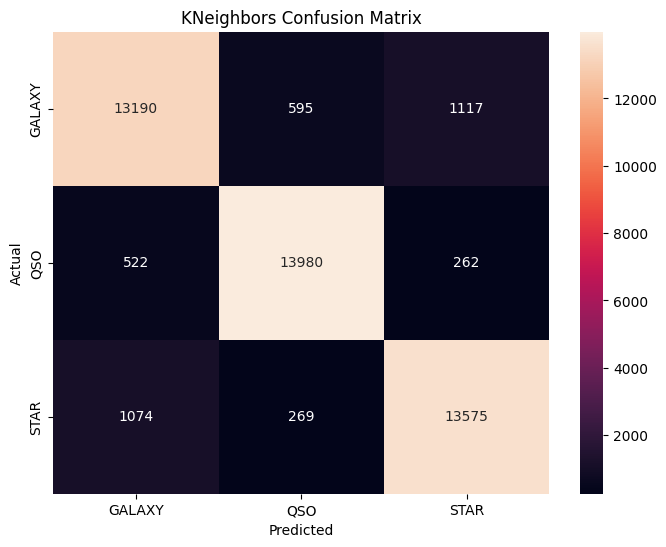

In [51]:
# Macierz pomyłek
conf_matrix_knn = confusion_matrix(y_test, y_pred1)

# Wizualizacja macierzy pomyłek za pomocą seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', xticklabels=['GALAXY', 'QSO', 'STAR'], yticklabels=['GALAXY', 'QSO', 'STAR'])
plt.title('KNeighbors Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


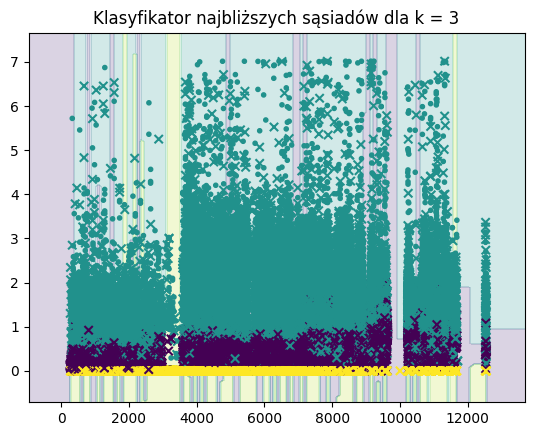

In [52]:
# Klasyfikacja dla dwóch przykładowych atrybutów plate(6) i redshift(5), u których wystąpiła jedna z najmniejszych korelacji
tablica = {"opis_ucz":X_train, "opis_test":X_test, "dec_ucz":y_train, "dec_test":y_test}
model = KNeighborsClassifier(n_neighbors=5)
granice(model,tablica,6,5,"Klasyfikator najbliższych sąsiadów dla k = 3")

### Drzewo decyzyjne

In [53]:
# Drzewo decyzyjne
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred3=dt.predict(X_test)
# Obliczanie dokładności klasyfikacji, na podstawie obu tych zbiorów
accuracy_dt = accuracy_score(y_test, y_pred3)
print(f"Accuracy for Decision Tree: {accuracy_dt:.3f}")

Accuracy for Decision Tree: 0.972


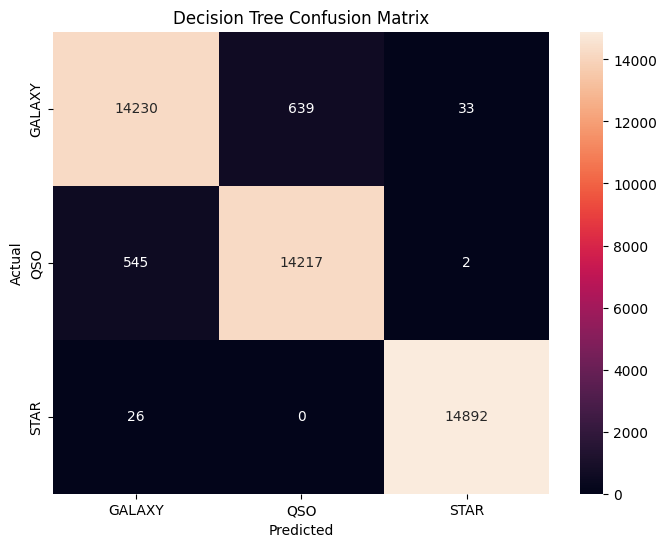

In [54]:
# Macierz pomyłek
conf_matrix_dt = confusion_matrix(y_test, y_pred3)

# Wizualizacja macierzy pomyłek za pomocą seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', xticklabels=['GALAXY', 'QSO', 'STAR'], yticklabels=['GALAXY', 'QSO', 'STAR'])
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


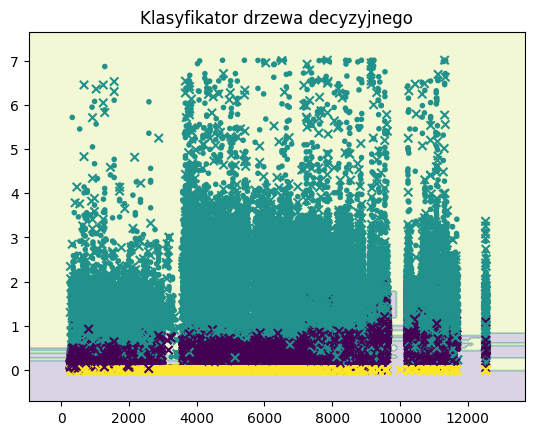

In [55]:
# Klasyfikacja dla dwóch przykładowych atrybutów plate(6) i redshift(5), u których wystąpiła jedna z najmniejszych korelacji
tablica = {"opis_ucz":X_train, "opis_test":X_test, "dec_ucz":y_train, "dec_test":y_test}
model = DecisionTreeClassifier()
granice(model,tablica,6,5,"Klasyfikator drzewa decyzyjnego")

### Klasyfikator Bayesa

In [56]:
# Klasyfikator Bayesa
nb=GaussianNB()
nb.fit(X_train,y_train)
predictNB=nb.predict(X_test)
# Obliczanie dokładności klasyfikacji, na podstawie obu tych zbiorów
accuracy_rf = accuracy_score(y_test, predictNB)
print(f"Accuracy for Gaussian Naive Base: {accuracy_rf:.3f}")

Accuracy for Gaussian Naive Base: 0.602


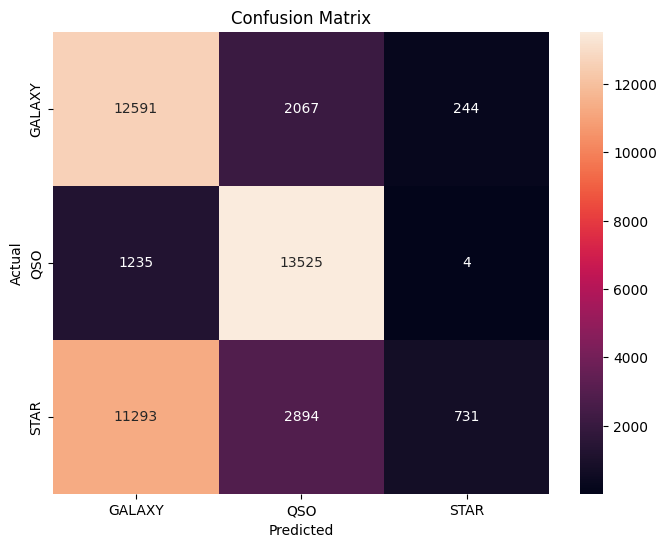

In [57]:
# Tworzenie macierzy pomyłek
conf_matrix = confusion_matrix(y_test, predictNB)
# Wizualizacja macierzy pomyłek za pomocą seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['GALAXY', 'QSO', 'STAR'], yticklabels=['GALAXY', 'QSO', 'STAR'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


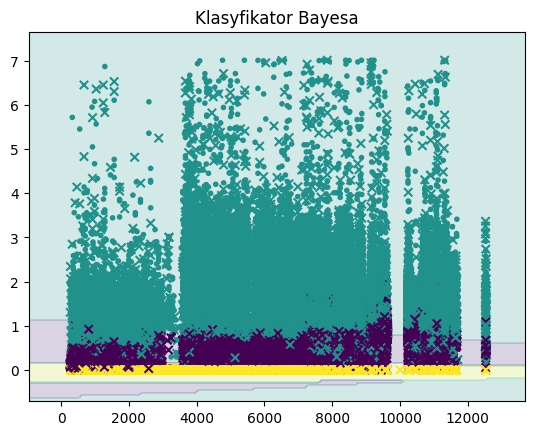

In [58]:
# Klasyfikacja dla dwóch przykładowych atrybutów plate(6) i redshift(5), u których wystąpiła jedna z najmniejszych korelacji
tablica = {"opis_ucz":X_train, "opis_test":X_test, "dec_ucz":y_train, "dec_test":y_test}
model = GaussianNB()
granice(model,tablica,6,5,"Klasyfikator Bayesa")



Dla porównania, tak prezentuje się wykres dla danych ogólnych:

<Figure size 600x500 with 0 Axes>

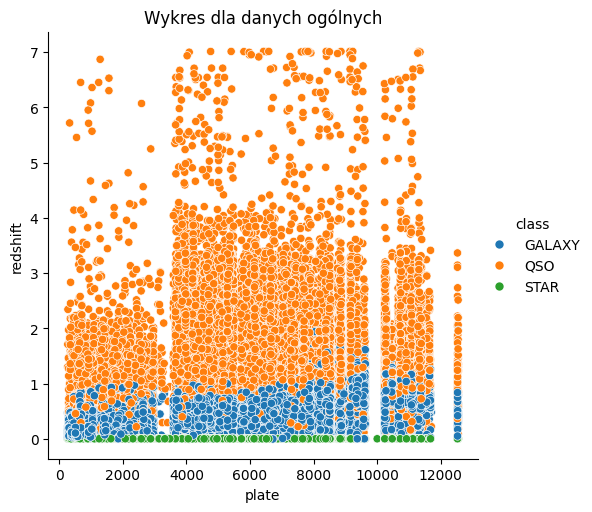

In [59]:
plt.figure(figsize=(6, 5))
sns.relplot(data=dane, x='plate', y='redshift', hue='class')
plt.title('Wykres dla danych ogólnych')
plt.show()

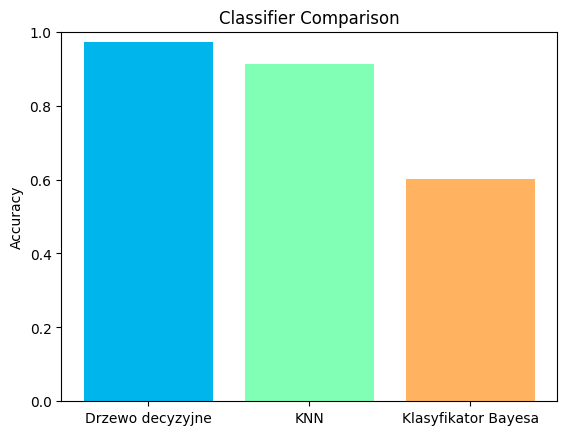

In [60]:
# Wykres porównawczy
classifiers = ['Drzewo decyzyjne', 'KNN', 'Klasyfikator Bayesa']
accuracies = [accuracy_dt, accuracy_knn1, accuracy_rf]

colors = sns.color_palette('rainbow', n_colors=len(classifiers))

plt.bar(classifiers, accuracies, color=colors)
plt.ylabel('Accuracy')
plt.title('Classifier Comparison')
plt.ylim(0, 1)  # Zakres osi y od 0 do 1
plt.show()

## Wnioski:

Na podstawie macierzy pomyłek i testów zgodności modelu testowego z modelem uczonym, możemy zauważyć, że z testowanych przez nas modeli klasyfikatorów najlepiej poradził sobie model drzewa decyzyjnego, którego zgodność wyniosła ponad 97%. Nastepnie klasyfikator najbliższych sąsiadów (91%) i na końcu Bayesa (60%). 